In [1]:
%pip install pandas matplotlib yfinance statsmodels scikit-learn

  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     --- ------------------------------------ 0.3/3.0 MB ? eta -:--:--
     ------ --------------------------------- 0.5/3.0 MB 1.4 MB/s eta 0:00:02
     ---------- ----------------------------- 0.8/3.0 MB 1.3 MB/s eta 0:00:02
     ---------- ----------------------------- 0.8/3.0 MB 1.3 MB/s eta 0:00:02
     ------------- -------------------------- 1.0/3.0 MB 986.7 kB/s eta 0:00:03
     ----------------- ---------------------- 1.3/3.0 MB 972.7 kB/s eta 0:00:02
     -------------------- ------------------- 1.6/3.0 MB 987.0 kB/s eta 0:00:02
     ------------------------ --------------- 1.8/3.0 MB 1.0 MB/s eta 0:00:02
     ------------------------ --------------- 1.8/3.0 MB 1.0 MB/s eta 0:00:02
     --------------------------- ------------ 2.1/3.0 MB 903.5 kB/s eta 0:00:02
     --

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.arima.model import ARIMA

## Key Idea

1. **Training Phase:**
    - Fetch historical price data for a basket of tickers and the target ticker.
    - Train a regression model to predict the target ticker's price based on the basket tickers.
    - Create a mean-reverting spread using the model's predictions and the actual target ticker prices.
    - Optimize the strategy by finding the best weights (threshold multipliers) to maximize the Sharpe ratio.
    - Ensure the spread is mean-reverting using the Augmented Dickey-Fuller (ADF) test.

2. **Testing Phase:**
    - Fetch historical price data for the test period.
    - Use the trained model to predict the target ticker's price during the test period.
    - Calculate the spread and generate buy/sell signals based on the optimized thresholds.
    - Evaluate the strategy's performance by calculating the Sharpe ratio and plotting the signals.

3. **Possible Improvements:**
    - Currently i have a n_purchase, that by right should purchase based on the spread * multiplier. You can see how you want to optimize that given that technically if its mean reverting, the larger the spread then the larger buy since it will go back to the mean.
    - You can try smoothing out the predictions, if you do a plot of the prediction and the actual youll see its not v smooth. removing outliers from predictions would be good.
    - Would rolling mean be better?


In [6]:
def get_price_data(tickers, start_date, end_date):
    """
    Fetches historical price data for a list of tickers from Yahoo Finance.

    Args:
        tickers (list): List of tickers to fetch.
        start_date (str): Start date for the data.
        end_date (str): End date for the data.

    Returns:
        pd.DataFrame: DataFrame with the closing prices for all tickers.
    """
    data = pd.DataFrame()
    for ticker in tickers:
        price_series = yf.download(ticker, start=start_date, end=end_date)[['Close']]
        price_series.columns = [ticker]
        data = pd.concat([data, price_series], axis=1)
    return data.dropna()

def train_regression_model(data, target_col):
    """
    Trains an OLS regression model to predict the target variable.

    Args:
        data (pd.DataFrame): DataFrame containing explanatory variables and the target.
        target_col (str): Name of the target column.

    Returns:
        statsmodels OLS model: Trained regression model.
    """
    X = add_constant(data.drop(columns=[target_col]))  # Explanatory variables
    y = data[target_col]  # Target variable
    model = OLS(y, X).fit()
    return model

import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

def plot_spread_with_signals(data, target_col, predicted_col, signal_col, rolling_window=50, n_signal=2):
    """
    Plots the spread between actual and predicted exchange rate values along with standard deviation bands,
    highlighting buy and sell signals with a rolling mean adjustment.
    
    Args:
        data (pd.DataFrame): DataFrame containing actual values, predicted values, spread, and signals.
        target_col (str): Name of the actual exchange rate column.
        predicted_col (str): Name of the predicted exchange rate column.
        signal_col (str): Name of the signal column.
        rolling_window (int): Window size for rolling mean calculation.
        n_signal (float): Number of standard deviations for signal thresholds.
    """
    # Ensure spread is calculated
    data['Spread'] = data[target_col] - data[predicted_col]
    
    # Compute rolling mean and standard deviation-based thresholds
    data['Rolling_Mean'] = data['Spread'].rolling(rolling_window).mean()
    data['Rolling_Std'] = data['Spread'].rolling(rolling_window).std()
    data['Threshold_Upper'] = data['Rolling_Mean'] + (n_signal * data['Rolling_Std'])
    data['Threshold_Lower'] = data['Rolling_Mean'] - (n_signal * data['Rolling_Std'])
    
    # Generate buy/sell signals based on rolling thresholds
    data['Signal'] = 0
    data.loc[data['Spread'] > data['Threshold_Upper'], 'Signal'] = -1  # Sell signal
    data.loc[data['Spread'] < data['Threshold_Lower'], 'Signal'] = 1  # Buy signal
    
    plt.figure(figsize=(12, 8))
    plt.plot(data.index, data['Spread'], label='Spread', color='black')
    plt.plot(data.index, data['Rolling_Mean'], label='Rolling Mean', color='blue', linestyle='--')
    plt.plot(data.index, data['Threshold_Upper'], color='red', linestyle='--', label='Sell Threshold')
    plt.plot(data.index, data['Threshold_Lower'], color='green', linestyle='--', label='Buy Threshold')
    plt.axhline(y=0, color='gray', linestyle='-', label='Zero Line')
    
    # Mark Buy and Sell signals
    plt.scatter(data.index[data['Signal'] > 0], data['Spread'][data['Signal'] > 0],
                color='green', marker='^', alpha=1, label='Buy Signal')
    plt.scatter(data.index[data['Signal'] < 0], data['Spread'][data['Signal'] < 0],
                color='red', marker='v', alpha=1, label='Sell Signal')
    
    plt.title('Spread Between Actual and Predicted SGD/USD with Rolling Mean Trading Signals')
    plt.xlabel('Time')
    plt.ylabel('Spread')
    plt.legend()
    plt.grid()
    plt.show()

def calculate_spread_and_signals(data, n_signal, n_purchase, target_col, predicted_col, rolling_window=50):
    """
    Calculates the spread and generates buy/sell signals based on rolling mean and standard deviation.
    
    Args:
        data (pd.DataFrame): DataFrame containing actual and predicted values.
        n_signal (float): Multiplier for standard deviation thresholds.
        n_purchase (float): Multiplier for position sizing.
        target_col (str): Name of the actual values column.
        predicted_col (str): Name of the predicted values column.
        rolling_window (int): Window size for rolling calculations.
    
    Returns:
        pd.DataFrame: Updated DataFrame with spread, thresholds, and signals.
    """
    data['Spread'] = data[target_col] - data[predicted_col]
    data['Rolling_Mean'] = data['Spread'].rolling(rolling_window).mean()
    data['Rolling_Std'] = data['Spread'].rolling(rolling_window).std()
    
    data['Threshold_Upper'] = data['Rolling_Mean'] + (n_signal * data['Rolling_Std'])
    data['Threshold_Lower'] = data['Rolling_Mean'] - (n_signal * data['Rolling_Std'])
    
    # Generate signals
    data['Signal'] = 0
    data.loc[data['Spread'] > data['Threshold_Upper'], 'Signal'] = -1 * n_purchase  # Sell signal
    data.loc[data['Spread'] < data['Threshold_Lower'], 'Signal'] = 1 * n_purchase  # Buy signal
    
    return data
def plot_signals(data, actual_col, signal_col, title):
    """
    Plots the actual values and overlays buy/sell signals.

    Args:
        data (pd.DataFrame): DataFrame containing actual values and signals.
        actual_col (str): Name of the actual values column.
        signal_col (str): Name of the signal column.
        title (str): Chart title.
    """
    plt.figure(figsize=(12, 8))
    plt.plot(data.index, data[actual_col], label='Actual USD/SGD', color='blue')
    plt.scatter(data.index[data[signal_col] > 0], data[actual_col][data[signal_col] > 0], 
                label='Buy Signal', color='green', marker='^', alpha=1)
    plt.scatter(data.index[data[signal_col] < 0], data[actual_col][data[signal_col] < 0], 
                label='Sell Signal', color='red', marker='v', alpha=1)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.grid()
    plt.show()
    
def adf_test(series, title=""):
    """
    Performs the Augmented Dickey-Fuller (ADF) test to check for stationarity.

    Args:
        series (pd.Series): The time series to test.
        title (str): Title for the test.

    Returns:
        dict: ADF test results.
    """
    result = adfuller(series.dropna())
    output = {
        "ADF Statistic": result[0],
        "p-value": result[1],
        "Critical Values": result[4]
    }
    print(f"--- ADF Test for {title} ---")
    print(f"ADF Statistic: {result[0]}")
    print(f"P-Value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    if result[1] < 0.05:
        print(f"The series is stationary (Reject null hypothesis of unit root).")
    else:
        print(f"The series is NOT stationary (Fail to reject null hypothesis).")
    print("\n")
    return output

def check_mean_reversion(series):
    """
    Fits an AR(1) model to test if the series is mean-reverting.

    Args:
        series (pd.Series): The time series to model.
    Returns:
        float: AR(1) coefficient (should be < 1 for mean-reversion).
    """
    model = ARIMA(series.dropna(), order=(1, 0, 0))  # AR(1) Model
    fitted_model = model.fit()
    
    ar1_coefficient = fitted_model.arparams[0]
    print(f"AR(1) Coefficient: {ar1_coefficient}")

    if abs(ar1_coefficient) < 1:
        print("The series is likely mean-reverting.")
    else:
        print("The series is not mean-reverting.")
    return ar1_coefficient

def optimize_thresholds(data, price_col, predicted_col, signal_col, target_col, n_signal_list, n_purchase_list):
    """
    Optimizes the threshold multipliers to maximize the Sharpe ratio.

    Args:
        data (pd.DataFrame): DataFrame containing prices and predictions.
        price_col (str): Name of the actual price column.
        predicted_col (str): Name of the predicted price column.
        signal_col (str): Name of the signal column.
        target_col (str): Name of the target column for spread.
        n_signal_list (list): Range of values for stdev signal threshold mult.
        n_purchase_list (list): Range of values for buying mult.

    Returns:
        dict: Dictionary containing the optimal multipliers and Sharpe ratio.
    """
    best_sharpe = float('-inf')
    best_n_signal = None
    best_n_purchase = None

    for n_signal in n_signal_list:
        for n_purchase in n_purchase_list:
            # Create spread and signals
            updated_data = calculate_spread_and_signals(data.copy(), n_signal, n_purchase, target_col, predicted_col)
            
            # Calculate Sharpe ratio
            sharpe_ratio = calculate_strategy_sharpe(updated_data, price_col=target_col, signal_col='Signal')

            # Update the best parameters if Sharpe ratio improves
            if sharpe_ratio > best_sharpe:
                best_sharpe = sharpe_ratio
                best_n_signal = n_signal
                best_n_purchase = n_purchase

    return {"best_n_signal": best_n_signal, "best_n_purchase": best_n_purchase, "Best_Sharpe_Ratio": best_sharpe}

def plot_residual_with_signals_optimal(data, target_col, predicted_col, signal_col, optimal_thresholds):
    """
    Plots the spread between actual and predicted exchange rate values along with standard deviation bands,
    highlighting buy and sell signals with a rolling mean adjustment and optimal parameters for Sharpe ratio maximization.
    
    Args:
        data (pd.DataFrame): DataFrame containing actual values, predicted values, spread, and signals.
        target_col (str): Name of the actual exchange rate column.
        predicted_col (str): Name of the predicted exchange rate column.
        signal_col (str): Name of the signal column.
        optimal_thresholds (dict): Dictionary containing optimized n_signal and n_purchase values.
        rolling_window (int, optional): Window size for rolling mean calculation. If None, uses an optimized value.
    """
    # Optimize rolling window size based on past performance
    #if rolling_window is None:
    #    rolling_window = int(len(data) * 0.1)  # Set to 10% of dataset length as a heuristic
    
    # Ensure spread is calculated
    data['Spread'] = data[target_col] - data[predicted_col]
    
    # Compute rolling mean and standard deviation-based thresholds
    data['Rolling_Mean'] = data['Spread'].rolling(optimal_thresholds['best_rolling_window']).mean()
    data['Rolling_Std'] = data['Spread'].rolling(optimal_thresholds['best_rolling_window']).std()
    
    # Apply optimized threshold multipliers
    data['Threshold_Upper'] = data['Rolling_Mean'] + (optimal_thresholds['best_n_signal'] * data['Rolling_Std'])
    data['Threshold_Lower'] = data['Rolling_Mean'] - (optimal_thresholds['best_n_signal'] * data['Rolling_Std'])
    
    # Generate signals based on optimal parameters
    data['Signal'] = 0
    data.loc[data['Spread'] > data['Threshold_Upper'], 'Signal'] = -1 * optimal_thresholds['best_n_purchase']
    data.loc[data['Spread'] < data['Threshold_Lower'], 'Signal'] = 1 * optimal_thresholds['best_n_purchase']
    
    plt.figure(figsize=(12, 8))
    plt.plot(data.index, data['Spread'], label='Spread', color='black')
    plt.plot(data.index, data['Rolling_Mean'], label=f'Rolling Mean (Window= {optimal_thresholds["best_rolling_window"]})', color='blue', linestyle='--')
    plt.plot(data.index, data['Threshold_Upper'], color='red', linestyle='--', label='Optimized Sell Threshold')
    plt.plot(data.index, data['Threshold_Lower'], color='green', linestyle='--', label='Optimized Buy Threshold')
    plt.axhline(y=0, color='gray', linestyle='-', label='Zero Line')
    
    # Mark Buy and Sell signals with scaled trade sizes
    plt.scatter(data.index[data['Signal'] > 0], data['Spread'][data['Signal'] > 0],
                color='green', marker='^', alpha=1, label=f'Buy Signal (x{optimal_thresholds["best_n_purchase"]})')
    plt.scatter(data.index[data['Signal'] < 0], data['Spread'][data['Signal'] < 0],
                color='red', marker='v', alpha=1, label=f'Sell Signal (x{optimal_thresholds["best_n_purchase"]})')
    
    plt.title('Residual Between Actual and Predicted SGD/USD with Optimized Trading Signals')
    plt.xlabel('Time')
    plt.ylabel('Spread')
    plt.legend()
    plt.grid()
    plt.show()

def calculate_max_drawdown(data, target_col, signal_col):
    """
    Calculates the maximum drawdown based on buy/sell signals.

    Args:
        data (pd.DataFrame): DataFrame containing price and signals.
        target_col (str): Column name for the price data.
        signal_col (str): Column name for the buy/sell signals.

    Returns:
        float: Maximum drawdown value.
    """
    data['Cumulative_Returns'] = (1 + data[target_col].pct_change() * data[signal_col].shift()).cumprod()
    data['Cumulative_Max'] = data['Cumulative_Returns'].cummax()
    data['Drawdown'] = data['Cumulative_Returns'] / data['Cumulative_Max'] - 1
    max_drawdown = data['Drawdown'].min()
    return max_drawdown

def calculate_total_profit(data, target_col, signal_col):
    """
    Calculates the total profit based on buy/sell signals.
    
    Args:
        data (pd.DataFrame): DataFrame containing price and signals.
        target_col (str): Column name for the price data.
        signal_col (str): Column name for the buy/sell signals.
    
    Returns:
        float: Total profit from the strategy.
    """
    data['Daily_Return'] = data[target_col].pct_change()
    data['Strategy_Return'] = data['Daily_Return'] * data[signal_col].shift()
    total_profit = data['Strategy_Return'].sum()
    return total_profit

def calculate_sharpe_ratio(data, target_col, signal_col, risk_free_rate):
    """
    Calculates the Sharpe ratio of the trading strategy using the US Treasury rate as the risk-free rate.
    
    Args:
        data (pd.DataFrame): DataFrame containing price and signals.
        target_col (str): Column name for the price data.
        signal_col (str): Column name for the buy/sell signals.
        risk_free_rate (float): Annualized risk-free rate (US Treasury rate) in decimal form.
    
    Returns:
        float: Sharpe ratio of the strategy.
    """
    data['Daily_Return'] = data[target_col].pct_change()
    data['Strategy_Return'] = data['Daily_Return'] * data[signal_col].shift()
    
    # Convert annual risk-free rate to daily risk-free rate
    daily_risk_free_rate = (1 + risk_free_rate) ** (1 / 252) - 1
    
    # Excess returns
    data['Excess_Return'] = data['Strategy_Return'] - daily_risk_free_rate
    
    # Calculate Sharpe ratio
    mean_excess_return = data['Excess_Return'].mean()
    std_excess_return = data['Excess_Return'].std()
    sharpe_ratio = (mean_excess_return / std_excess_return) * np.sqrt(252)
    
    return sharpe_ratio

#------------------------------#

def optimize_thresholds(data, price_col, predicted_col, signal_col, target_col, n_signal_list, n_purchase_list, rolling_window_list):
    """
    Optimizes the threshold multipliers and rolling window to maximize the Sharpe ratio.
    
    Args:
        data (pd.DataFrame): DataFrame containing prices and predictions.
        price_col (str): Name of the actual price column.
        predicted_col (str): Name of the predicted price column.
        signal_col (str): Name of the signal column.
        target_col (str): Name of the target column for spread.
        n_signal_list (list): Range of values for stdev signal threshold mult.
        n_purchase_list (list): Range of values for buying mult.
        rolling_window_list (list): Range of values for rolling mean window.
    
    Returns:
        dict: Dictionary containing the optimal multipliers, rolling window, and Sharpe ratio.
    """
    best_sharpe = float('-inf')
    best_n_signal = None
    best_n_purchase = None
    best_rolling_window = None

    for rolling_window in rolling_window_list:
        for n_signal in n_signal_list:
            for n_purchase in n_purchase_list:
                # Create spread and signals with rolling window
                updated_data = calculate_spread_and_signals(data.copy(), n_signal, n_purchase, target_col, predicted_col, rolling_window)
                
                # Calculate Sharpe ratio
                sharpe_ratio = calculate_strategy_sharpe(updated_data, price_col=target_col, signal_col='Signal')
                
                # Update the best parameters if Sharpe ratio improves
                if sharpe_ratio > best_sharpe:
                    best_sharpe = sharpe_ratio
                    best_n_signal = n_signal
                    best_n_purchase = n_purchase
                    best_rolling_window = rolling_window

    return {"best_n_signal": best_n_signal, "best_n_purchase": best_n_purchase, "best_rolling_window": best_rolling_window, "Best_Sharpe_Ratio": best_sharpe}

def calculate_strategy_sharpe(data, price_col, signal_col):
    """
    Calculates the Sharpe ratio for a trading strategy based on buy/sell signals.

    Args:
        data (pd.DataFrame): DataFrame with price and signals.
        price_col (str): Column name for the price data.
        signal_col (str): Column name for the buy/sell signals.

    Returns:
        float: Sharpe ratio of the strategy.
    """
    # Calculate daily returns
    data['Daily_Return'] = data[price_col].pct_change()

    # Calculate positions based on cumulative signals
    data['Position'] = data[signal_col].cumsum()

    # Calculate portfolio returns
    data['Portfolio_Return'] = data['Position'].shift() * data['Daily_Return']

    # Drop NaN values from the first shift
    data = data.dropna()

    # Calculate Sharpe ratio
    mean_return = data['Portfolio_Return'].mean()
    std_dev_return = data['Portfolio_Return'].std()
    sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)

    return sharpe_ratio



In [4]:
# Downloading data from MAS, converting into points on graph and plotting it 
nr_file_path = "C:/Users/Vidret/OneDrive - Nanyang Technological University/Documents/Y2S2/IBC/Winter Project/Nominal Effective Exchange Rate Index.xlsx"
nrdf = pd.read_excel(nr_file_path, parse_dates=[0])
nrdf.columns = ["Date","NEER_Index"]
filtered_nrdf = nrdf[nrdf["Date"] > "2018-01-01"]

#Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_nrdf["Date"], filtered_nrdf["NEER_Index"], linestyle='-')

#formatting
plt.xlabel("Date")
plt.ylabel("NEER Nominal Index")
plt.title("NEER Index Over Time (After 2018)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Vidret/OneDrive - Nanyang Technological University/Documents/Y2S2/IBC/Winter Project/Nominal Effective Exchange Rate Index.xlsx'

--- ADF Test for Original NEER Series ---
ADF Statistic: -1.476438929831225
P-Value: 0.5451328074539568
Critical Values:
   1%: -3.4483935212959844
   5%: -2.8694912343676497
   10%: -2.571005879151811
The series is NOT stationary (Fail to reject null hypothesis).




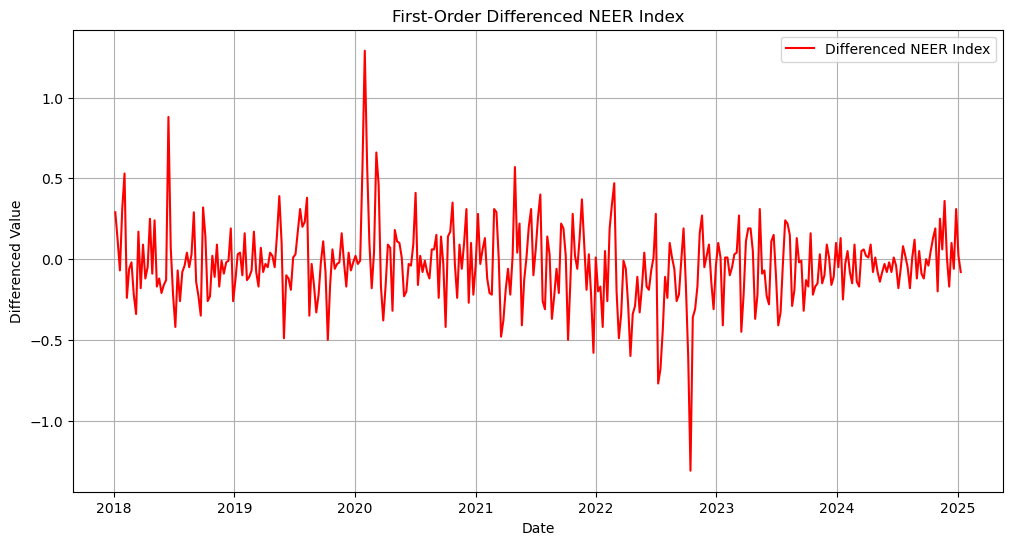

--- ADF Test for Differenced NEER Series ---
ADF Statistic: -8.707559865102127
P-Value: 3.665056450244374e-14
Critical Values:
   1%: -3.448493650810824
   5%: -2.8695352280356556
   10%: -2.5710293341377715
The series is stationary (Reject null hypothesis of unit root).


AR(1) Coefficient: 0.2982789830947896
The series is likely mean-reverting.


C:\Users\Vidret\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Vidret\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Vidret\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


0.2982789830947896

In [ ]:
nrdf = pd.read_excel(nr_file_path, parse_dates=[0])

# Rename columns if necessary
nrdf.columns = ["Date", "NEER_Index"]

# Filter data after 2018
nrdf = nrdf[nrdf["Date"] > "2018-01-01"]

# Run ADF test on raw NEER index
adf_test(nrdf["NEER_Index"], title="Original NEER Series")

# First-order differencing
nrdf["NEER_Diff"] = nrdf["NEER_Index"].diff()

# Plot the differenced NEER series
plt.figure(figsize=(12,6))
plt.plot(nrdf["Date"], nrdf["NEER_Diff"], label="Differenced NEER Index", color="red")
plt.title("First-Order Differenced NEER Index")
plt.xlabel("Date")
plt.ylabel("Differenced Value")
plt.legend()
plt.grid()
plt.show()

# Run ADF test on differenced NEER index
adf_test(nrdf["NEER_Diff"], title="Differenced NEER Series")

# Check for mean-reversion using AR(1) model
check_mean_reversion(nrdf["NEER_Diff"])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Model Summary:
                            OLS Regression Results                            
Dep. Variable:               SGDUSD=X   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.549e+04
Date:                Mon, 03 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:23:49   Log-Likelihood:                 5718.8
No. Observations:                1043   AIC:                        -1.141e+04
Df Residuals:                    1027   BIC:                        -1.133e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0723      0.005     

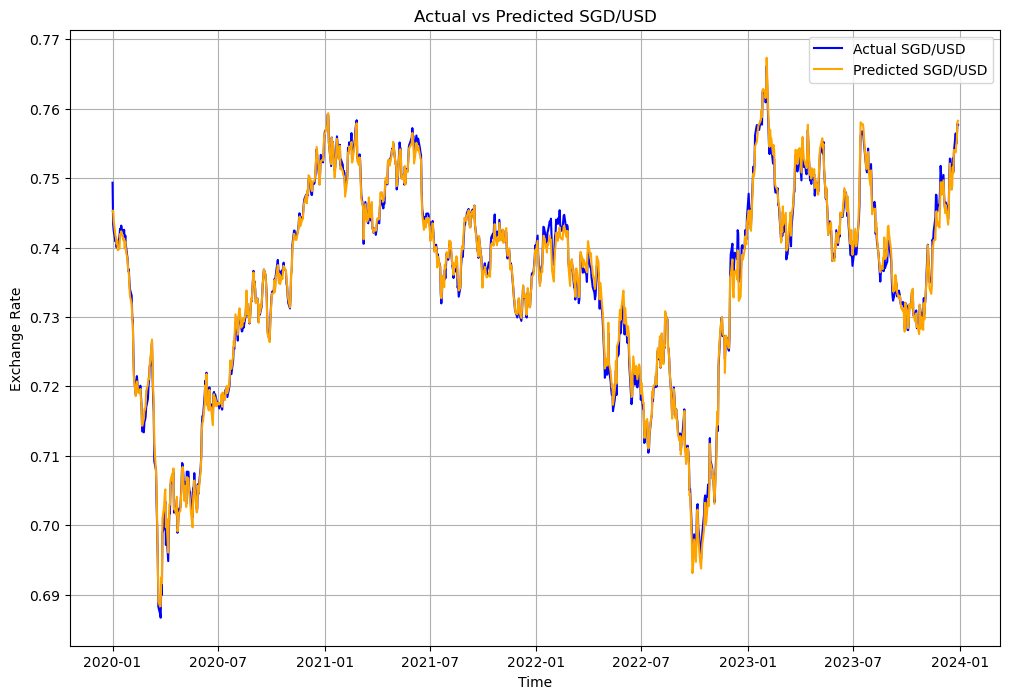

In [ ]:
basket_tickers = [
"SGDEUR=X",
"SGDGBP=X",
"SGDAUD=X",
"SGDCNY=X",
"SGDHKD=X",
"SGDINR=X",
"SGDIDR=X",
"SGDJPY=X",
"SGDKRW=X",
"SGDMYR=X",
"SGDTWD=X",
"SGDNZD=X",
"SGDCHF=X",
"SGDTHB=X",
"SGDAED=X",
]
target_ticker = 'SGDUSD=X'
all_tickers = basket_tickers + [target_ticker]

b_start_date = '2020-01-01'
b_end_date = '2024-01-01'
t_start_date = '2024-01-01'
t_end_date = '2025-01-01'

train_data = get_price_data(all_tickers, b_start_date, b_end_date)
model = train_regression_model(train_data, target_ticker)
# Print model summary
print("Model Summary:")
print(model.summary())

train_data['Predicted_SGD/USD'] = model.predict(add_constant(train_data[basket_tickers]))

# Plot the actual and predicted values
plt.figure(figsize=(12, 8))
plt.plot(train_data.index, train_data[target_ticker], label='Actual SGD/USD', color='blue')
plt.plot(train_data.index, train_data['Predicted_SGD/USD'], label='Predicted SGD/USD', color='orange')
plt.title('Actual vs Predicted SGD/USD')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for each currency pair
X = add_constant(train_data[basket_tickers])  # Add constant to the independent variables
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


     Feature          VIF
0      const  9012.512437
1   SGDEUR=X     5.895868
2   SGDGBP=X     8.655731
3   SGDAUD=X    18.054404
4   SGDCNY=X     5.408529
5   SGDHKD=X    35.324966
6   SGDINR=X    13.379569
7   SGDIDR=X     2.137589
8   SGDJPY=X     6.704181
9   SGDKRW=X    10.091378
10  SGDMYR=X     6.231834
11  SGDTWD=X     5.074070
12  SGDNZD=X    16.410834
13  SGDCHF=X     3.204273
14  SGDTHB=X     4.389928
15  SGDAED=X    36.616185


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Model Summary:
                            OLS Regression Results                            
Dep. Variable:               SGDUSD=X   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     96.87
Date:                Mon, 03 Feb 2025   Prob (F-statistic):          7.50e-141
Time:                        22:14:35   Log-Likelihood:                 3234.4
No. Observations:                1043   AIC:                            -6447.
Df Residuals:                    1032   BIC:                            -6392.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6969      0.042     

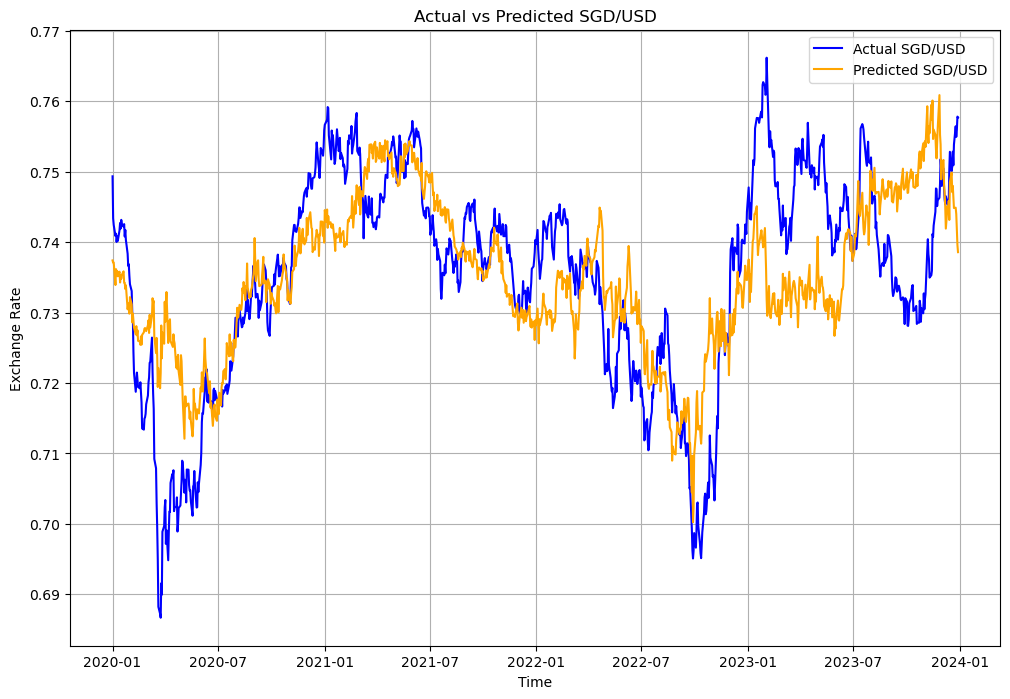

In [ ]:
basket_tickers = [
"SGDEUR=X",
"SGDGBP=X",
"SGDCNY=X",
"SGDIDR=X",
"SGDJPY=X",
"SGDKRW=X",
"SGDMYR=X",
"SGDTWD=X",
"SGDCHF=X",
"SGDTHB=X",
]
target_ticker = 'SGDUSD=X'
all_tickers = basket_tickers + [target_ticker]

b_start_date = '2020-01-01'
b_end_date = '2024-01-01'
t_start_date = '2024-01-01'
t_end_date = '2025-01-01'

train_data = get_price_data(all_tickers, b_start_date, b_end_date)
model = train_regression_model(train_data, target_ticker)
# Print model summary
print("Model Summary:")
print(model.summary())

train_data['Predicted_SGD/USD'] = model.predict(add_constant(train_data[basket_tickers]))

# Plot the actual and predicted values
plt.figure(figsize=(12, 8))
plt.plot(train_data.index, train_data[target_ticker], label='Actual SGD/USD', color='blue')
plt.plot(train_data.index, train_data['Predicted_SGD/USD'], label='Predicted SGD/USD', color='orange')
plt.title('Actual vs Predicted SGD/USD')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid()
plt.show()

                            OLS Regression Results                            
Dep. Variable:               SGDUSD=X   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     123.3
Date:                Mon, 03 Feb 2025   Prob (F-statistic):          1.78e-102
Time:                        22:14:37   Log-Likelihood:                 3132.5
No. Observations:                1043   AIC:                            -6253.
Df Residuals:                    1037   BIC:                            -6223.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7351      0.000   1971.382      0.0

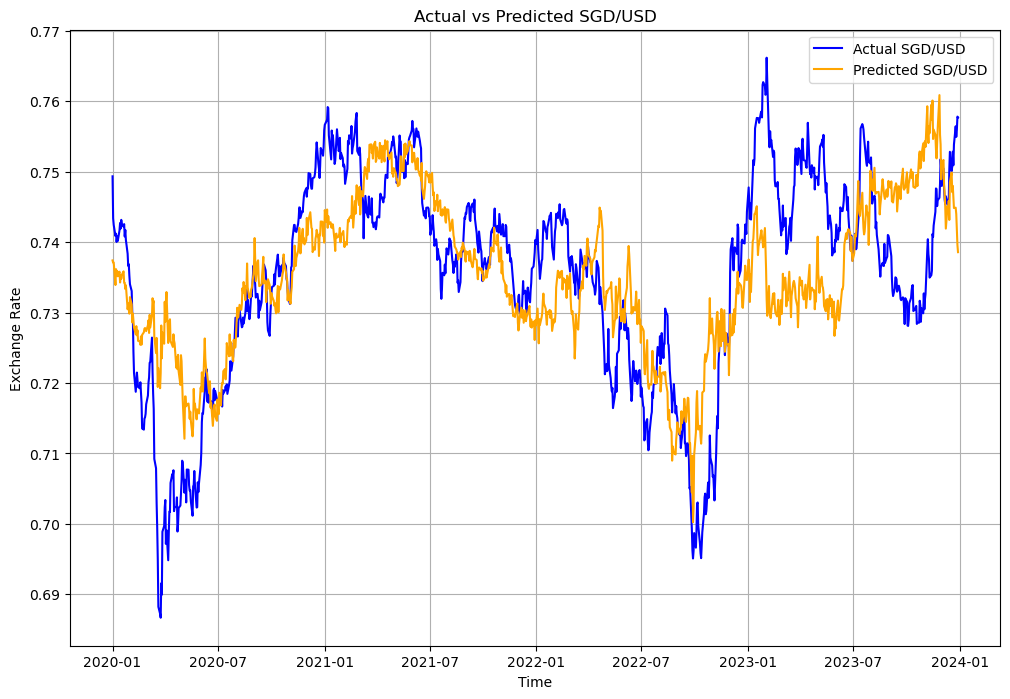

In [ ]:
from sklearn.decomposition import PCA

# Standardize the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_data[basket_tickers])

# Apply PCA
pca = PCA(n_components=5)  # Reduce to 5 uncorrelated factors
pca_data = pca.fit_transform(scaled_data)

# Create DataFrame with transformed features
pca_df = pd.DataFrame(pca_data, index=train_data.index, columns=[f'PC{i+1}' for i in range(5)])

# Train model on PCA components instead of original tickers
model = train_regression_model(pca_df.join(train_data[target_ticker]), target_ticker)
print(model.summary())

# Plot the actual and predicted values
plt.figure(figsize=(12, 8))
plt.plot(train_data.index, train_data[target_ticker], label='Actual SGD/USD', color='blue')
plt.plot(train_data.index, train_data['Predicted_SGD/USD'], label='Predicted SGD/USD', color='orange')
plt.title('Actual vs Predicted SGD/USD')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid()
plt.show()

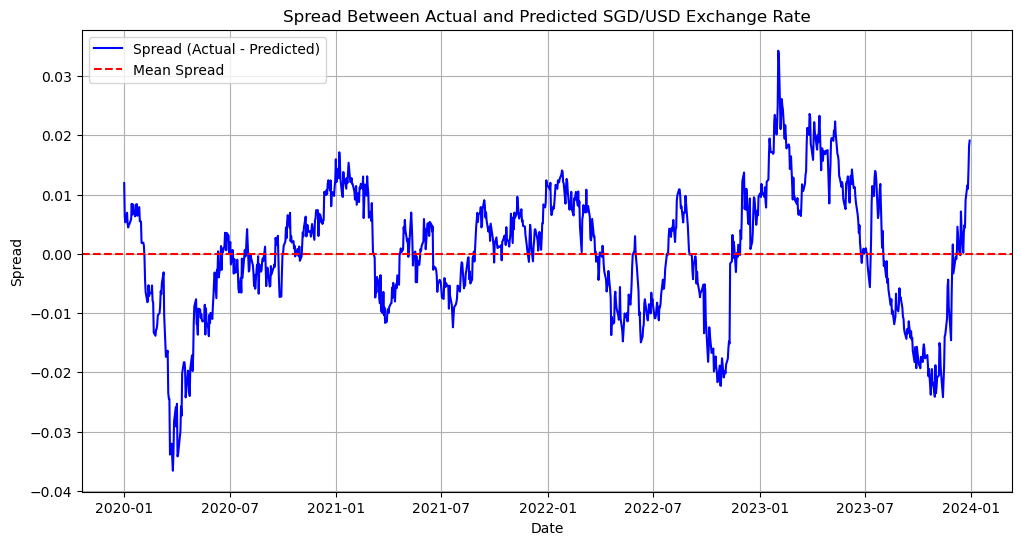

--- ADF Test for Spread Between Actual and Predicted SGD/USD ---
ADF Statistic: -3.0615981232923506
P-Value: 0.02952873822980257
Critical Values:
   1%: -3.436671659540904
   5%: -2.8643311477003515
   10%: -2.5682561222519897
The series is stationary (Reject null hypothesis of unit root).




C:\Users\Vidret\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\Vidret\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\Vidret\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


AR(1) Coefficient: 0.9732752257853614
The series is likely mean-reverting.


C:\Users\Vidret\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.9732752257853614

In [ ]:
# Assuming `train_data` contains actual SGD/USD and predicted SGD/USD
target_ticker = 'SGDUSD=X'  # Change this if necessary
spread = train_data[target_ticker] - train_data['Predicted_SGD/USD']

# Plot the spread over time
plt.figure(figsize=(12,6))
plt.plot(spread, label="Spread (Actual - Predicted)", color="blue")
plt.axhline(spread.mean(), color='red', linestyle='--', label="Mean Spread")
plt.title("Spread Between Actual and Predicted SGD/USD Exchange Rate")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend()
plt.grid()
plt.show()

# Run ADF test on the spread
adf_results = adf_test(spread, title="Spread Between Actual and Predicted SGD/USD")

# Check for mean reversion using AR(1) model
check_mean_reversion(spread)




In [ ]:

# Define the US Treasury risk-free rate (example: 3% annualized rate)
risk_free_rate = 0.03

# Example rolling window range
rolling_window_list = [10, 20, 50, 100, 200]

# Optimize thresholds
optimal_thresholds = optimize_thresholds(train_data, target_ticker, 'Predicted_SGD/USD', 'Signal', target_ticker, np.arange(0.1, 3.1, 0.1), np.arange(0.1, 3.1, 0.1), rolling_window_list)

print("Optimal Threshold Multipliers and Sharpe Ratio:")
print(optimal_thresholds)

C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_

C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_

Optimal Threshold Multipliers and Sharpe Ratio:
{'best_n_signal': 1.3000000000000003, 'best_n_purchase': 1.5000000000000002, 'best_rolling_window': 200, 'Best_Sharpe_Ratio': 1.4853631936502356}


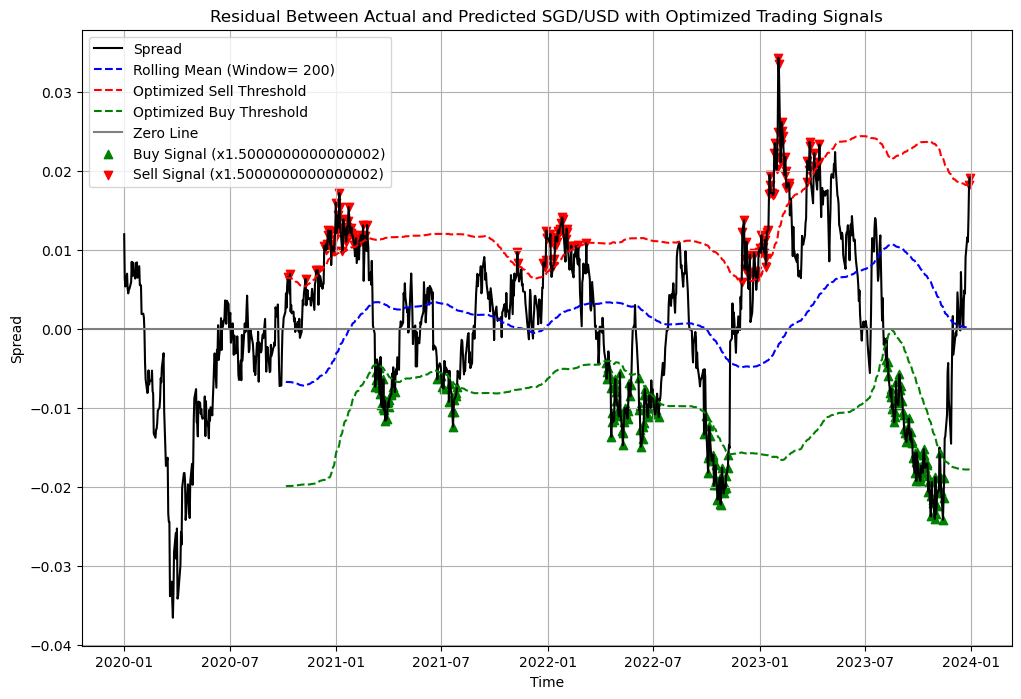

Maximum Drawdown: -0.05
Total Profit: 0.07
Sharpe Ratio: 1.49


In [ ]:
# Call the function with optimal thresholds and dynamic rolling window
plot_residual_with_signals_optimal(train_data, target_ticker, 'Predicted_SGD/USD', 'Signal', optimal_thresholds)
max_drawdown = calculate_max_drawdown(train_data, target_ticker, 'Signal')
total_profit = calculate_total_profit(train_data, target_ticker, 'Signal')
sharpe_ratio = calculate_strategy_sharpe(train_data, target_ticker, signal_col='Signal')
                       
print(f"Maximum Drawdown: {max_drawdown:.2f}")
print(f"Total Profit: {total_profit:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


In [ ]:
# Step 1: Fetch new data (2024-2025)
test_data = get_price_data(all_tickers, t_start_date, t_end_date)

# Step 2: Standardize the new data using the previously fitted scaler
scaled_test_data = scaler.transform(test_data[basket_tickers])  # Use the same fitted scaler

# Step 3: Apply PCA transformation using the trained PCA model
pca_test_data = pca.transform(scaled_test_data)  # Use the same fitted PCA

# Step 4: Convert PCA components into DataFrame
pca_test_df = pd.DataFrame(pca_test_data, index=test_data.index, columns=[f'PC{i+1}' for i in range(5)])

# Step 5: Predict SGD/USD using trained regression model
test_data['Predicted_SGD/USD'] = model.predict(add_constant(pca_test_df))

# Step 6: Plot actual vs predicted values for new data
plot_residual_with_signals_optimal(test_data, target_ticker, 'Predicted_SGD/USD', 'Signal')
# Step 7: Evaluate performance (Mean Squared Error)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_data[target_ticker], test_data['Predicted_SGD/USD'])
print(f"Mean Squared Error on 2024 Data: {mse:.6f}")
max_drawdown = calculate_max_drawdown(test_data, target_ticker, 'Signal')
total_profit = calculate_total_profit(test_data, target_ticker, 'Signal')
sharpe_ratio = calculate_strategy_sharpe(test_data, target_ticker, 'Signal')

print(f"Maximum Drawdown: {max_drawdown:.6f}")
print(f"Total Profit: {total_profit:.6f}")
print(f"Sharpe Ratio: {sharpe_ratio:.6f}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


TypeError: list indices must be integers or slices, not str

In [ ]:

# Define the US Treasury risk-free rate (example: 3% annualized rate)
risk_free_rate = 0.03
rolling_window_list = [10]
# Optimize thresholds
optimal_thresholds =optimize_thresholds(train_data, target_ticker, 'Predicted_SGD/USD', 'Signal', target_ticker, np.arange(0.1, 3.1, 0.1), np.arange(0.1, 3.1, 0.1), rolling_window_list)

print("Optimal Threshold Multipliers and Sharpe Ratio:")
print(optimal_thresholds)

C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)


Optimal Threshold Multipliers and Sharpe Ratio:
{'best_n_signal': 1.0, 'best_n_purchase': 1.7000000000000002, 'best_rolling_window': 10, 'Best_Sharpe_Ratio': 1.2468322272258345}


In [ ]:
def plot_residual_with_signals_optimal_rw(data, target_col, predicted_col, signal_col, optimal_thresholds, rolling_window):
    """
    Plots the spread between actual and predicted exchange rate values along with standard deviation bands,
    highlighting buy and sell signals with a rolling mean adjustment and optimal parameters for Sharpe ratio maximization.
    
    Args:
        data (pd.DataFrame): DataFrame containing actual values, predicted values, spread, and signals.
        target_col (str): Name of the actual exchange rate column.
        predicted_col (str): Name of the predicted exchange rate column.
        signal_col (str): Name of the signal column.
        optimal_thresholds (dict): Dictionary containing optimized n_signal and n_purchase values.
        rolling_window (int, optional): Window size for rolling mean calculation. If None, uses an optimized value.
    """
    # Optimize rolling window size based on past performance
    #if rolling_window is None:
    #    rolling_window = int(len(data) * 0.1)  # Set to 10% of dataset length as a heuristic
    
    # Ensure spread is calculated
    data['Spread'] = data[target_col] - data[predicted_col]
    
    # Compute rolling mean and standard deviation-based thresholds
    data['Rolling_Mean'] = data['Spread'].rolling(rolling_window).mean()
    data['Rolling_Std'] = data['Spread'].rolling(rolling_window).std()
    
    # Apply optimized threshold multipliers
    data['Threshold_Upper'] = data['Rolling_Mean'] + (optimal_thresholds['best_n_signal'] * data['Rolling_Std'])
    data['Threshold_Lower'] = data['Rolling_Mean'] - (optimal_thresholds['best_n_signal'] * data['Rolling_Std'])
    
    # Generate signals based on optimal parameters
    data['Signal'] = 0
    data.loc[data['Spread'] > data['Threshold_Upper'], 'Signal'] = -1 * optimal_thresholds['best_n_purchase']
    data.loc[data['Spread'] < data['Threshold_Lower'], 'Signal'] = 1 * optimal_thresholds['best_n_purchase']
    
    plt.figure(figsize=(12, 8))
    plt.plot(data.index, data['Spread'], label='Spread', color='black')
    plt.plot(data.index, data['Rolling_Mean'], label=f'Rolling Mean (Window= {rolling_window})', color='blue', linestyle='--')
    plt.plot(data.index, data['Threshold_Upper'], color='red', linestyle='--', label='Optimized Sell Threshold')
    plt.plot(data.index, data['Threshold_Lower'], color='green', linestyle='--', label='Optimized Buy Threshold')
    plt.axhline(y=0, color='gray', linestyle='-', label='Zero Line')
    
    # Mark Buy and Sell signals with scaled trade sizes
    plt.scatter(data.index[data['Signal'] > 0], data['Spread'][data['Signal'] > 0],
                color='green', marker='^', alpha=1, label=f'Buy Signal (x{optimal_thresholds["best_n_purchase"]})')
    plt.scatter(data.index[data['Signal'] < 0], data['Spread'][data['Signal'] < 0],
                color='red', marker='v', alpha=1, label=f'Sell Signal (x{optimal_thresholds["best_n_purchase"]})')
    
    plt.title('Residual Between Actual and Predicted SGD/USD with Optimized Trading Signals')
    plt.xlabel('Time')
    plt.ylabel('Spread')
    plt.legend()
    plt.grid()
    plt.show()


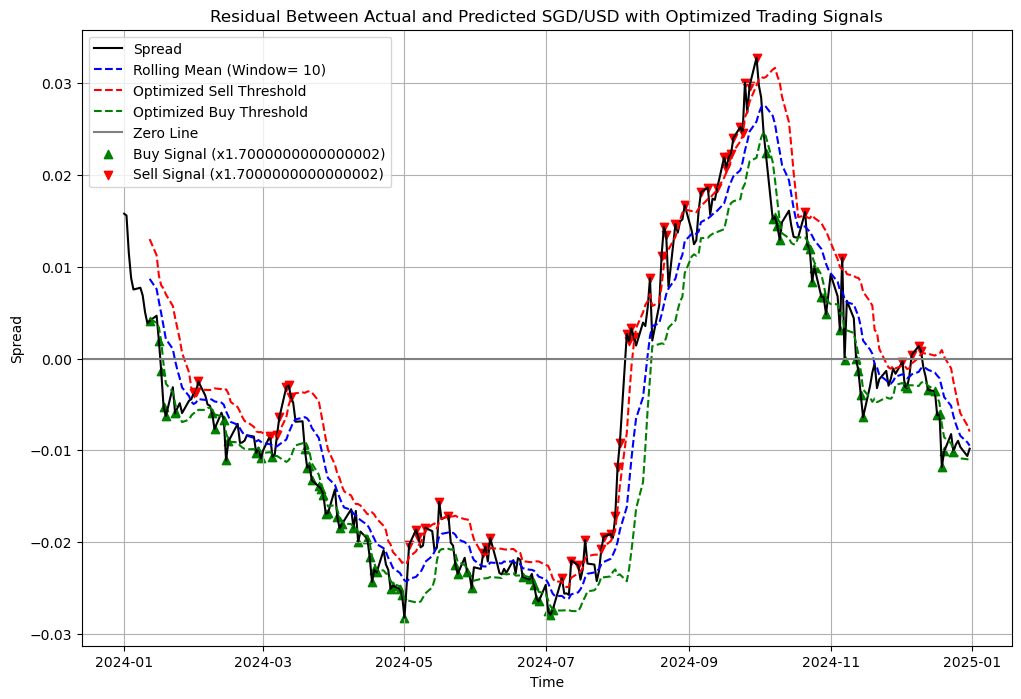

In [ ]:
plot_residual_with_signals_optimal(test_data, target_ticker, 'Predicted_SGD/USD', 'Signal', optimal_thresholds)

In [ ]:
max_drawdown = calculate_max_drawdown(test_data, target_ticker, 'Signal')
total_profit = calculate_total_profit(test_data, target_ticker, 'Signal')
sharpe_ratio = calculate_strategy_sharpe(test_data, target_ticker, 'Signal')

print(f"Maximum Drawdown: {max_drawdown:.6f}")
print(f"Total Profit: {total_profit:.6f}")
print(f"Sharpe Ratio: {sharpe_ratio:.6f}")

Maximum Drawdown: -0.028697
Total Profit: 0.040155
Sharpe Ratio: 0.835882


In [ ]:
b_start_date = '2014-01-01'
b_end_date = '2024-01-01'

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Model Summary:
                            OLS Regression Results                            
Dep. Variable:               SGDUSD=X   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     583.9
Date:                Mon, 03 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:48:01   Log-Likelihood:                 7600.4
No. Observations:                2565   AIC:                        -1.518e+04
Df Residuals:                    2554   BIC:                        -1.511e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7821      0.016     

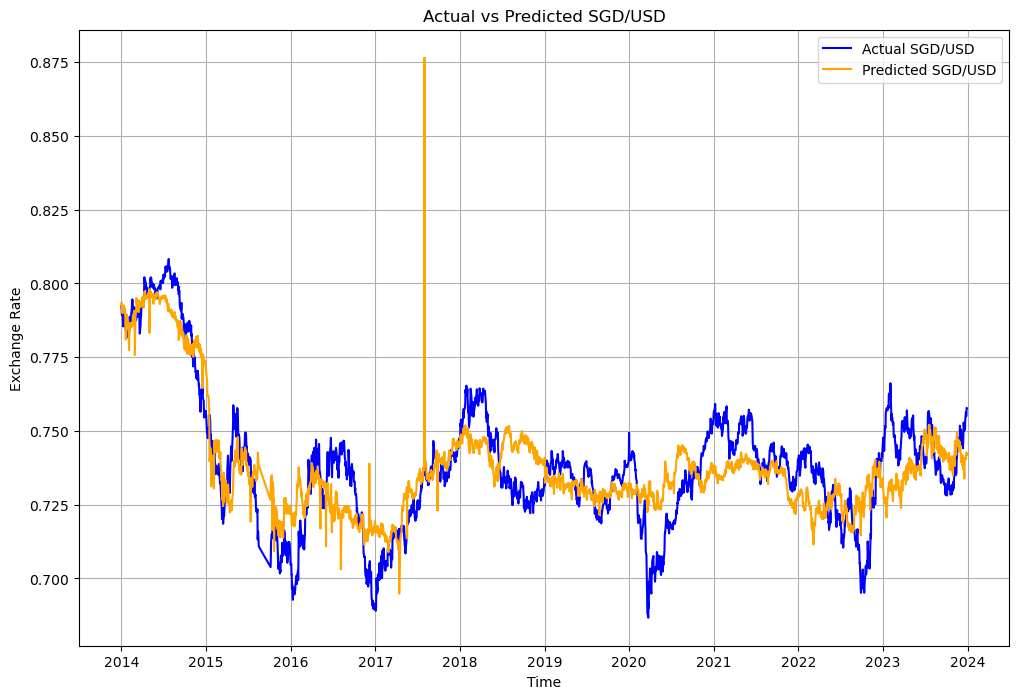

In [ ]:
train_data = get_price_data(all_tickers, b_start_date, b_end_date)
model = train_regression_model(train_data, target_ticker)
# Print model summary
print("Model Summary:")
print(model.summary())

train_data['Predicted_SGD/USD'] = model.predict(add_constant(train_data[basket_tickers]))

from sklearn.decomposition import PCA

# Standardize the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_data[basket_tickers])

# Apply PCA
pca = PCA(n_components=5)  # Reduce to 5 uncorrelated factors
pca_data = pca.fit_transform(scaled_data)

# Create DataFrame with transformed features
pca_df = pd.DataFrame(pca_data, index=train_data.index, columns=[f'PC{i+1}' for i in range(5)])

# Train model on PCA components instead of original tickers
model = train_regression_model(pca_df.join(train_data[target_ticker]), target_ticker)
print(model.summary())

plt.figure(figsize=(12, 8))
plt.plot(train_data.index, train_data[target_ticker], label='Actual SGD/USD', color='blue')
plt.plot(train_data.index, train_data['Predicted_SGD/USD'], label='Predicted SGD/USD', color='orange')
plt.title('Actual vs Predicted SGD/USD')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Define the US Treasury risk-free rate (example: 3% annualized rate)
risk_free_rate = 0.03

# Example rolling window range
rolling_window_list = [10, 20, 50, 100, 200]

# Optimize thresholds
optimal_thresholds = optimize_thresholds(train_data, target_ticker, 'Predicted_SGD/USD', 'Signal', target_ticker, np.arange(0.1, 3.1, 0.1), np.arange(0.1, 3.1, 0.1), rolling_window_list)

print("Optimal Threshold Multipliers and Sharpe Ratio:")
print(optimal_thresholds)

C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_

C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_14228\898926001.py:411: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)
C:\Users\Vidret\AppData\Local\Temp\ipykernel_

Optimal Threshold Multipliers and Sharpe Ratio:
{'best_n_signal': 0.5, 'best_n_purchase': 0.5, 'best_rolling_window': 200, 'Best_Sharpe_Ratio': 1.0073542740159818}


In [ ]:
test_data = get_price_data(all_tickers, t_start_date, t_end_date)
test_data['Predicted_SGD/USD'] = model.predict(add_constant(test_data[basket_tickers]))
# Call the function to plot the spread and signals
plot_residual_with_signals_optimal(test_data, target_ticker, 'Predicted_SGD/USD', 'Signal', optimal_thresholds)

# Calculate max drawdown and total profit
risk_free_rate = 0.03
max_drawdown = calculate_max_drawdown(test_data, target_ticker, 'Signal')
total_profit = calculate_total_profit(test_data, target_ticker, 'Signal')
sharpe_ratio = calculate_strategy_sharpe(test_data, target_ticker, 'Signal', risk_free_rate)

print(f"Maximum Drawdown: {max_drawdown:.6f}")
print(f"Total Profit: {total_profit:.6f}")
print(f"Sharpe Ratio: {sharpe_ratio:.6f}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


ValueError: shapes (262,11) and (6,) not aligned: 11 (dim 1) != 6 (dim 0)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

def plot_spread_with_signals(data, target_col, predicted_col, signal_col, rolling_window=50):
    """
    Plots the spread between actual and predicted exchange rate values along with standard deviation bands,
    highlighting buy and sell signals with a rolling mean adjustment.
    
    Args:
        data (pd.DataFrame): DataFrame containing actual values, predicted values, spread, and signals.
        target_col (str): Name of the actual exchange rate column.
        predicted_col (str): Name of the predicted exchange rate column.
        signal_col (str): Name of the signal column.
        rolling_window (int): Window size for rolling mean calculation.
    """
    # Ensure spread is calculated
    data['Spread'] = data[target_col] - data[predicted_col]
    
    # Compute rolling mean and standard deviation-based thresholds
    data['Rolling_Mean'] = data['Spread'].rolling(rolling_window).mean()
    data['Rolling_Std'] = data['Spread'].rolling(rolling_window).std()
    data['Threshold_Upper'] = data['Rolling_Mean'] + (2 * data['Rolling_Std'])
    data['Threshold_Lower'] = data['Rolling_Mean'] - (2 * data['Rolling_Std'])
    
    # Generate buy/sell signals based on rolling thresholds
    data['Signal'] = 0
    data.loc[data['Spread'] > data['Threshold_Upper'], 'Signal'] = -1  # Sell signal
    data.loc[data['Spread'] < data['Threshold_Lower'], 'Signal'] = 1  # Buy signal
    
    plt.figure(figsize=(12, 8))
    plt.plot(data.index, data['Spread'], label='Spread', color='black')
    plt.plot(data.index, data['Rolling_Mean'], label='Rolling Mean', color='blue', linestyle='--')
    plt.plot(data.index, data['Threshold_Upper'], color='red', linestyle='--', label='Sell Threshold')
    plt.plot(data.index, data['Threshold_Lower'], color='green', linestyle='--', label='Buy Threshold')
    plt.axhline(y=0, color='gray', linestyle='-', label='Zero Line')
    
    # Mark Buy and Sell signals
    plt.scatter(data.index[data['Signal'] > 0], data['Spread'][data['Signal'] > 0],
                color='green', marker='^', alpha=1, label='Buy Signal')
    plt.scatter(data.index[data['Signal'] < 0], data['Spread'][data['Signal'] < 0],
                color='red', marker='v', alpha=1, label='Sell Signal')
    
    plt.title('Spread Between Actual and Predicted SGD/USD with Rolling Mean Trading Signals')
    plt.xlabel('Time')
    plt.ylabel('Spread')
    plt.legend()
    plt.grid()
    plt.show()

def optimize_basket_sharpe(data, target_col, basket_tickers, max_basket_size=5):
    """
    Automates backtesting by selecting the optimal basket of tickers that maximizes the Sharpe ratio.
    
    Args:
        data (pd.DataFrame): DataFrame containing prices.
        target_col (str): Name of the target column.
        basket_tickers (list): List of potential tickers to include in the basket.
        max_basket_size (int): Maximum number of tickers in the basket.
    
    Returns:
        dict: Best basket of tickers and corresponding Sharpe ratio.
    """
    best_sharpe = float('-inf')
    best_basket = None
    
    for size in range(1, max_basket_size + 1):
        for subset in combinations(basket_tickers, size):
            model = train_regression_model(data[list(subset) + [target_col]], target_col)
            data['Predicted'] = model.predict(add_constant(data[list(subset)]))
            
            # Generate trading signals
            data_with_signals = calculate_spread_and_signals(data.copy(), 2, 1, target_col, 'Predicted')
            sharpe_ratio = calculate_strategy_sharpe(data_with_signals, target_col, 'Signal')
            
            if sharpe_ratio > best_sharpe:
                best_sharpe = sharpe_ratio
                best_basket = subset
    
    return {"best_basket": best_basket, "best_sharpe": best_sharpe}

# Optimize basket
optimal_basket = optimize_basket_sharpe(train_data, target_ticker, basket_tickers, max_basket_size=5)
print(f"Optimal Basket: {optimal_basket['best_basket']}")
print(f"Best Sharpe Ratio: {optimal_basket['best_sharpe']:.6f}")


C:\Users\Vidret\AppData\Local\Temp\ipykernel_10652\1035281339.py:391: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)


Optimal Basket: ('SGDCNY=X', 'SGDINR=X', 'SGDMYR=X', 'SGDCHF=X')
Best Sharpe Ratio: 1.345693


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Model Summary:
                            OLS Regression Results                            
Dep. Variable:               SGDUSD=X   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.549e+04
Date:                Mon, 03 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:38:19   Log-Likelihood:                 5718.8
No. Observations:                1043   AIC:                        -1.141e+04
Df Residuals:                    1027   BIC:                        -1.133e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0723      0.005     

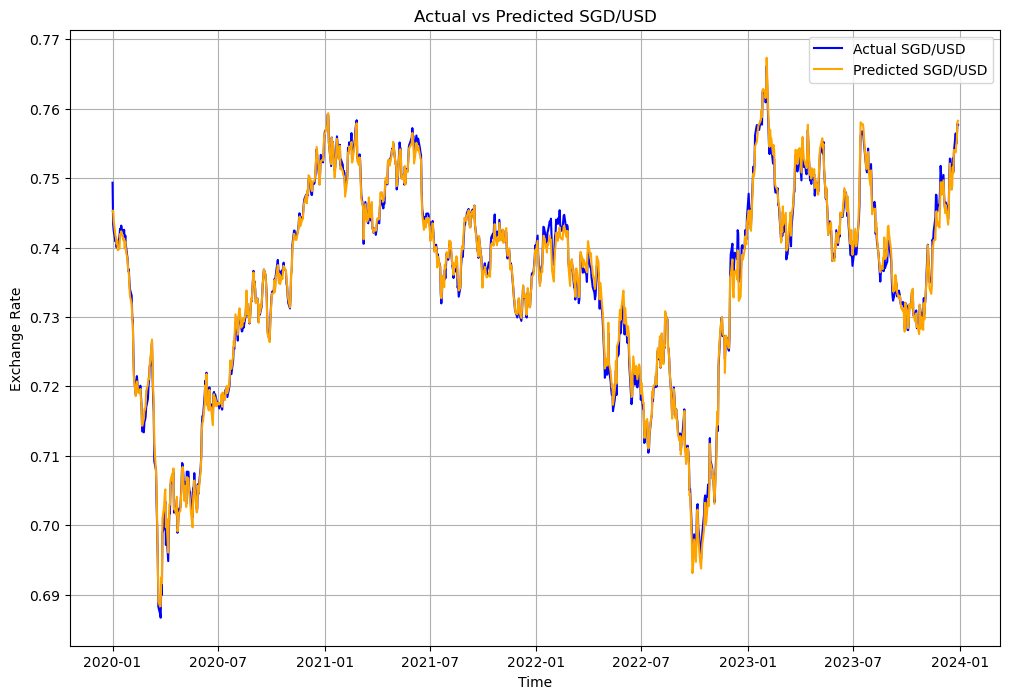

In [ ]:
basket_tickers = [
"SGDEUR=X",
"SGDGBP=X",
"SGDAUD=X",
"SGDCNY=X",
"SGDHKD=X",
"SGDINR=X",
"SGDIDR=X",
"SGDJPY=X",
"SGDKRW=X",
"SGDMYR=X",
"SGDTWD=X",
"SGDNZD=X",
"SGDCHF=X",]
target_ticker = 'SGDUSD=X'
all_tickers = basket_tickers + [target_ticker]

b_start_date = '2020-01-01'
b_end_date = '2024-01-01'
t_start_date = '2024-01-01'
t_end_date = '2025-01-01'

train_data = get_price_data(all_tickers, b_start_date, b_end_date)
model = train_regression_model(train_data, target_ticker)
# Print model summary
print("Model Summary:")
print(model.summary())

train_data['Predicted_SGD/USD'] = model.predict(add_constant(train_data[basket_tickers]))

# Plot the actual and predicted values
plt.figure(figsize=(12, 8))
plt.plot(train_data.index, train_data[target_ticker], label='Actual SGD/USD', color='blue')
plt.plot(train_data.index, train_data['Predicted_SGD/USD'], label='Predicted SGD/USD', color='orange')
plt.title('Actual vs Predicted SGD/USD')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid()
plt.show()

In [ ]:
train_data = get_price_data(all_tickers, b_start_date, b_end_date)
model = train_regression_model(train_data, target_ticker)
# Print model summary
print("Model Summary:")
print(model.summary())

train_data['Predicted_SGD/USD'] = model.predict(add_constant(train_data[basket_tickers]))

NameError: name 'get_price_data' is not defined

In [ ]:

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(train_data[target_ticker], train_data['Predicted_SGD/USD'])
print(f"\nMean Squared Error (MSE): {mse:.6f}")

n_purchase_list = np.arange(0.1, 3.1, 0.1)
n_signal_list = np.arange(0.1, 3.1, 0.1)

# Optimize thresholds
optimal_thresholds = optimize_thresholds(
    data=train_data,
    price_col=target_ticker,
    predicted_col='Predicted_SGD/USD',
    signal_col='Signal',
    target_col=target_ticker,
    n_purchase_list=n_purchase_list,
    n_signal_list=n_signal_list
)

print("Optimal Threshold Multipliers and Sharpe Ratio:")
print(optimal_thresholds)

NameError: name 'mean_squared_error' is not defined

In [ ]:
train_data = calculate_spread_and_signals(train_data, optimal_thresholds['best_n_signal'], optimal_thresholds['best_n_purchase'], target_col=target_ticker, predicted_col='Predicted_SGD/USD')
print("\nSharpe Ratio:", calculate_strategy_sharpe(train_data, target_ticker, signal_col='Signal'),"\n")
mean_reversion_test(train_data['Spread'])

In [ ]:
test_data = get_price_data(all_tickers, t_start_date, t_end_date)
test_data['Predicted_SGD/USD'] = model.predict(add_constant(test_data[basket_tickers]))

# Calculate spread and signals
test_data = calculate_spread_and_signals(test_data, optimal_thresholds['best_n_signal'], optimal_thresholds['best_n_purchase'], target_col=target_ticker, predicted_col='Predicted_SGD/USD')

# Plot signals
plot_signals(test_data, actual_col=target_ticker, signal_col='Signal', title='SGD/USD with Buy/Sell Signals')

In [ ]:
sharpe_ratio = calculate_strategy_sharpe(test_data, target_ticker, signal_col='Signal')
print(f"Sharpe Ratio of the strategy: {sharpe_ratio:.2f}")

Sharpe Ratio of the strategy: 1.05
